In [1]:
# Adapted from code at https://www.steadforce.com/how-tos/explainable-object-detection

# Import necessary packages

from mmdet.apis import init_detector, inference_detector

import random

import timeit

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import cv2

from PIL import Image

import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda:0')

/home/codylong/anaconda3/envs/mmdet_shap/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Here we define a couple functions that we need: non-maximal supression, box IoU, and a conversion to grey-scale
# from color for visualization purposes.

# This function is adapted from yolov5. One small edit, since our model directly outputs bounding box coordinates,
# instead of center position of bounding box and offsets. A more major edit is that our models output a list
# dectections-per-class, instead of a detection with a list of class probabilities. For the moment we will restrict
# to single-class detectors.

def non_max_suppression(prediction,
                        conf_thres=0.25,
                        iou_thres=0.45,
                        max_det=300):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping bounding boxes

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    prediction = torch.tensor(prediction, device='cuda:0' )

    #print("shape: ", prediction.shape)
    bs = prediction.shape[0]  # batch size
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()

    output = [torch.zeros((0, 5), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        x = x[xc[xi]]  # confidence

        # If none remain process next image
        if not x.shape[0]:
            continue
        
        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = x[:, :4] # I think already in correct format?

        # Detections matrix nx5 (xyxy, conf)
        conf = x[:, 4:]
        #x = torch.cat((box, conf), 1)[conf.view(-1) > conf_thres]
        x = torch.cat((box, conf), 1)

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        boxes, scores = x[:, :4], x[:, 4]  # boxes , scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]

        output[xi] = x[i]

    return output

def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [3]:
# Set the image size that we'll rescale our images to. This should be an integer multiple of the super-pixel size.

img_size = 20*16

pixel_division = 12
n_super_pixel = pixel_division**2

# xshape, yshape = img_org.shape[:2]

In [4]:
# xshape//pixel_division*pixel_division

In [5]:
# new_size_x = xshape//pixel_division*pixel_division
# new_size_y = yshape//pixel_division*pixel_division

In [6]:
# xshape

(427, 640)
636
420
new sizes:  636 420


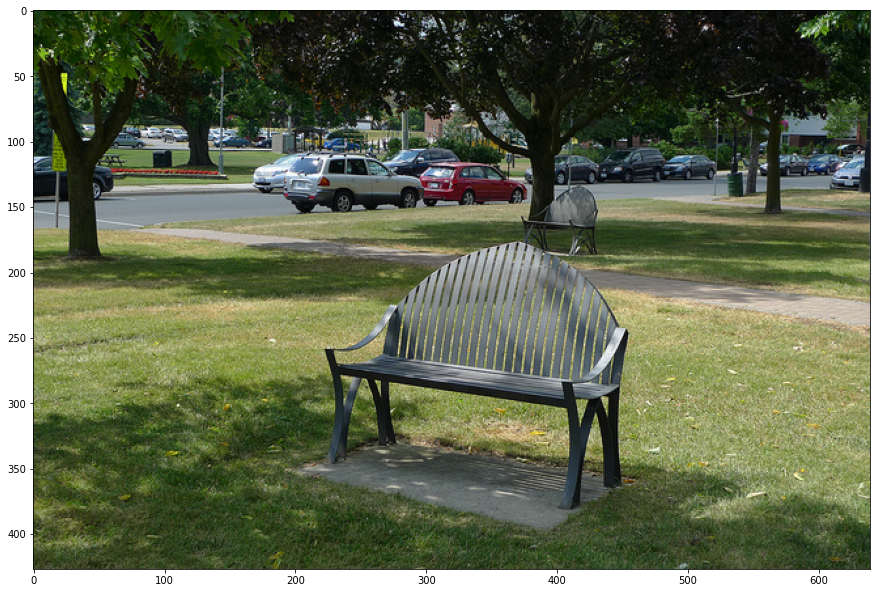

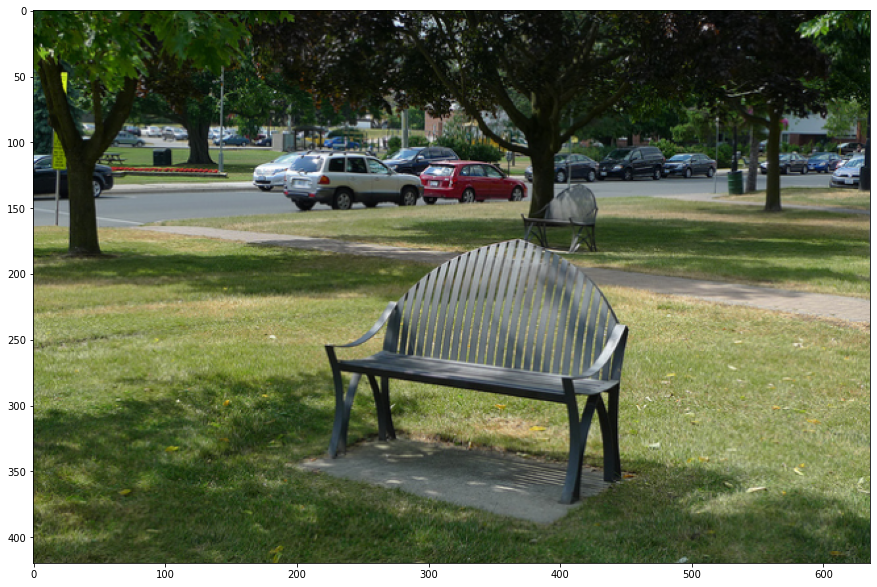

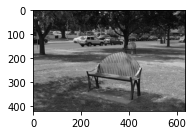

In [7]:
# Set the image path, and then load it in and visualize. We show the original, the scaled version, and the
# grayscale. 

img_path = 'demo/demo.jpg'

img_org = cv2.imread(img_path, cv2.IMREAD_COLOR)

#img_org = cv2.imread(img_path)

img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

# Set the image size that we'll rescale our images to. This should be an integer multiple of the super-pixel size.

# img_size = 20*16

pixel_division = 12

xshape, yshape = img_org.shape[:2]

old_img_size = img_org.shape[:2] # old size is in (height, width) format

print(old_img_size)

ratio = float(img_size)/max(old_img_size)
# new_size_y, new_size_x = tuple([int(x*ratio) for x in old_img_size])
# print(new_size_y)
# print(new_size_x)

xstep = xshape//pixel_division
ystep = yshape//pixel_division

new_size_x = xstep*pixel_division
new_size_y = ystep*pixel_division

print(new_size_y)
print(new_size_x)

print("new sizes: ", new_size_y, new_size_x)
img = cv2.resize(img_org, (new_size_y, new_size_x))

# delta_w = img_size - new_size_x
# delta_h = img_size - new_size_y
# top, bottom = delta_h//2, delta_h-(delta_h//2)
# left, right = delta_w//2, delta_w-(delta_w//2)
# print(top, bottom, left, right)

# color = [0, 0, 0]
# img2 = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
img2 = img.astype("float64")/255

img_gray = rgb2gray(img2)    

plt.figure(figsize=(15, 15))
plt.imshow(img_org)
plt.show()

fig = plt.figure(figsize=(15, 15))
#plt.subplot(1, 2, 1)
plt.imshow(img)
plt.show()
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
# Load in the model of interest, and set the confidence and IoU thresholds. 0.5 for both seems
# pretty standard.

config_file = 'configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

model = init_detector(config_file, checkpoint_file, device='cuda:0')

confidence = 0.5
iou = 0.5

load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [9]:
full_pred = inference_detector(model, img)

"ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.


In [10]:
len(full_pred)

80

In [11]:
# Run the image through the model. We print the bounding box coordinates as well as the confidence score
# for the prediction.
#print(img)
# The raw prediction
full_pred = inference_detector(model, img)

# After NMS
all_outs = [non_max_suppression(prediction, conf_thres=confidence, iou_thres=iou) for prediction in full_pred]

# all_out = [non_max_suppression(full_pred, conf_thres=confidence, iou_thres=iou)]
# for prediction in full_pred:
#     all_outs.append(non_max_suppression(prediction, conf_thres=confidence, iou_thres=iou))
# print(output[0], "#[x1, y1, x2, y2, confidence score]")


[[478.37534   108.271996  518.80884   128.23714     0.9934948]]
[[292.63986  114.08028  377.36728  148.17715    0.973286]]
[[  0.         108.21086     60.899094   141.5371       0.97248626]]
[[427.9203    104.124756  481.26364   130.93399     0.9646653]]
[[586.8749    108.55903   613.38446   124.3663      0.9569814]]
[[604.7357     107.47885    631.1625     134.55626      0.95306396]]
[[368.96588  108.072556 430.93442  131.76369    0.949092]]
[[185.7463     107.083496   296.54352    152.20782      0.94109076]]
[[551.7132    107.8903    588.83636   125.364716    0.9156222]]
[[166.93266   106.020134  211.3183    137.52509     0.8627896]]
[[266.3236    103.19685   323.0684    127.98719     0.8572137]]
[[5.6903497e+02 1.0860916e+02 5.9046759e+02 1.2486700e+02 5.1263678e-01]]
[[216.17836    178.03833    459.3258     379.4913       0.95479226]]
[[371.89227   132.31276   430.5567    184.86664     0.5110987]]
[[371.24704   133.84251   429.27423   184.99553     0.8186917]]


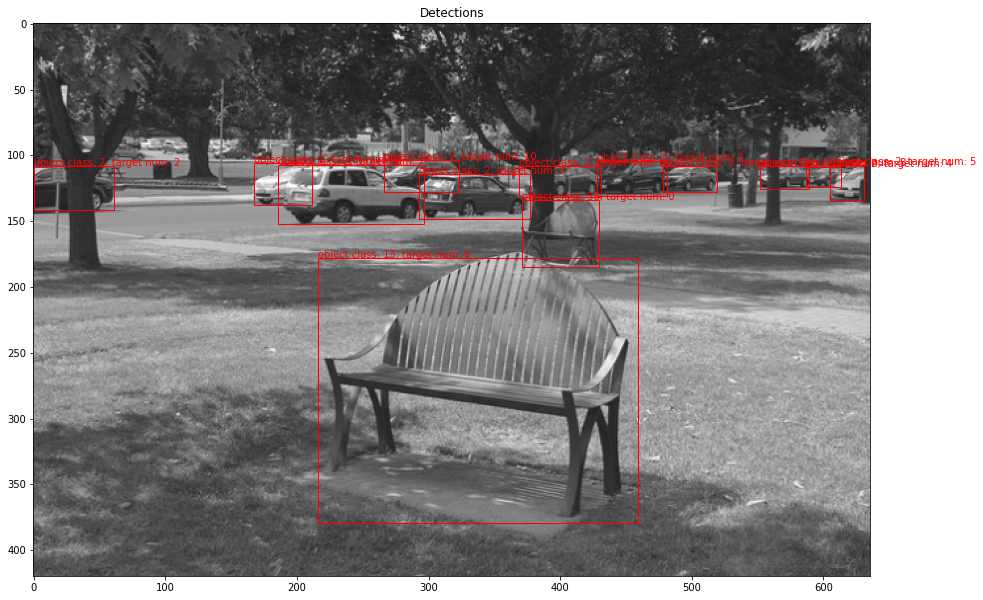

In [12]:
# Plot image and bounding boxes of detection

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title("Detections")
ax.imshow(img_gray, alpha=0.9, cmap='gray', vmin=0, vmax=1)
score_thresh = 0.8
for obj_num, obj_class in enumerate(all_outs):
    for targ_num, targ in enumerate(obj_class):
        tar = targ.cpu().numpy()
        label = "object class: " + str(obj_num) + ', target num: '+ str(targ_num)
        #print(tar)
        if tar.any():
            print(tar)
            tar = tar[0]
            if tar[4] >= score_thresh:
                plt.text(tar[0], tar[1], label, color="red")
                bbox = patches.Rectangle(tar[:2], tar[2]-tar[0], tar[3]-tar[1], linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(bbox)
plt.show()

In [13]:
# This is the scoring function: it assigns a score to each point in simplified input space. The score is assigned
# by the box IoU of the feature-adjusted predition with the original prediction, weighted by the confidence score
# of the feature-adjusted prediction. 
# We have a few natural options for object detection. One option is whether or not to combine the scores of multiple
# detections (which might be a good idea when the object is large and the exclusion of pixels could break it
# up into multiple components), and whether to weight tthe box IoU by confidence score. By default we do not
# combine and we do weight.

class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.001, iou_thresh=0.5, combine = False, scoreless = False):
        """
        constructor
        """
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)
        self.combine = combine
        self.scoreless = scoreless

    def forward(self, x):
        """
        In the forward function we accept the predictions and return the score for a selected target of the box
        """
        score_best_box = torch.zeros(len(x), device=device)
        #print(torch.tensor(x).shape)
        for idx, img in enumerate(x): # for each batch (detection of interest)
            #img = torch.tensor(img).unsqueeze(0)
            #print(img.shape)
            if len(img[0]) != 0:
              # perform nms on the detections
                output = non_max_suppression(img, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)
                if self.combine:
                    if output and output[0] is not None:
                        class_predictions = output[0][...,4]
                        boxes = output[0]

                        if boxes.shape[0]:
                            iou_with_targets= box_iou(boxes[:,:4], self.target.unsqueeze(0)[:,:4])

                            prescore = 0
                            if self.scoreless:
                                 for i in range(len(output[0])):
                                    prescore += iou_with_targets[i]
                            else:
                                for i in range(len(output[0])):
                                    prescore += output[0][i][4]*iou_with_targets[i]
                            score_best_box[idx] = torch.tensor(prescore)
                    
                else:
                    if output and output[0] is not None:
                        class_predictions = output[0][...,4]
                        boxes = output[0]
                        if boxes.shape[0]:
                            iou_with_target, _idx = box_iou(boxes[:,:4], self.target[:,:4]).max(1)
                            index_best_box = torch.argmax(iou_with_target)
                            if self.scoreless:
                                score_best_box[idx] = iou_with_target[index_best_box]
                            else:
                                score_best_box[idx] = output[0][index_best_box][4]*iou_with_target[index_best_box]

        return score_best_box.cpu().numpy()
    


In [14]:
# look at the image output above and set the index of the object you want to analyze here
class_index = 13
target_index = 0
target = all_outs[class_index][target_index].cpu().numpy()
print(target)
#scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou, combine = True, scoreless = True)
scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou)

print(scoring.forward([target]), "# score for target prediction")

[[216.17836    178.03833    459.3258     379.4913       0.95479226]]
[0.95479226] # score for target prediction


In [25]:
# This class defines the super-pixler, which combines nearby pixels intto a single one to define a simplified
# input space for shap.

class SuperPixler(torch.nn.Module):
  def __init__(self, image, super_pixel_width, xstep, ystep):
    super(SuperPixler, self).__init__()
    
    # print(image.shape)
    #self.image = image.transpose(2, 0, 1) # model expects images in BRG, not RGB, so transpose color channels
    # print(self.image.shape)
    self.image = image
    
    self.mean_color = self.image.mean()
    self.image = np.expand_dims(self.image, axis=0)
    self.image_width = image.shape[1]
    self.super_pixel_width = super_pixel_width
    self.xstep = xstep
    self.ystep = ystep

  
  def forward(self, x):
    """
    In the forward step we accept the super pixel masks and transform them to a batch of images
    """
#     pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)

#     for i, super_pixel in enumerate(x.T):
#       images_to_pixelate = [bool(p) for p in super_pixel]
#       x = (i*self.super_pixel_width//self.image_width)*self.super_pixel_width
#       y = i*self.super_pixel_width%self.image_width
#       pixeled_image[images_to_pixelate,:,x:x+self.super_pixel_width, y:y+self.super_pixel_width] = self.mean_color
        
    pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)
    print(x.T.shape)
    for i, super_pixel in enumerate(x.T):
      images_to_pixelate = [bool(p) for p in super_pixel]
      x = (i*self.xstep//self.image_width)*self.xstep
      # y = i*self.xstep%self.image_width
      y = i*self.xstep%self.image_width
      print(len(images_to_pixelate))
      pixeled_image[images_to_pixelate,:,x:x+self.xstep, y:y+self.ystep] = self.mean_color
    
    return pixeled_image


# Set the super pixel width, which must divide the image size
super_pixel_width = 32
assert (img_size/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"   
n_super_pixel = int((img.shape[1]/super_pixel_width)**2)

super_pixler = SuperPixler(img, super_pixel_width = super_pixel_width, xstep = xstep, ystep = ystep)

In [26]:
n_super_pixel

395

In [27]:
# Visualize the effect of super pixelization
img_s = super_pixler.forward(np.array([[0 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], 
                                       [random.randint(0,1) for _ in range(n_super_pixel)], 
                                       [0 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)]]))
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
# ax1.set_title("image top half super pixels hidden")
ax1.imshow(img_s[0,:,:,:].transpose(1,2,0))
ax1.imshow(img_s[0,:,:,:])
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("image random half super pixels hidden")
ax2.imshow(img_s[1,:,:,:].transpose(1,2,0))
# ax2.imshow(img_s[1,:,:,:])
plt.show()

(3,)
394


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 394

In [ ]:
# For shap, we want to create a map from simplified input space to a score to evvaluate feature importance.
# Our pipeline is then image -> super pixler -> model -> score. We use torch's sequentual module for this.

# Define a torch module who's forward pass evaluates the model on an input image.
class MMModel(nn.Module):
    def __init__(self, mmdet_model, class_index):
        super().__init__()
        self.mmmodel = mmdet_model
        self.class_index = class_index

    def forward(self, x):
        to_return = []
        for im in x:
            xx = im
            xx = xx.transpose(1, 2, 0)
            xx = inference_detector(self.mmmodel, xx)[self.class_index]
            to_return.append([xx])
        return to_return
    
#     def forward(self, x):
#         print(x.shape)
#         x = x.transpose(0, 2, 3, 1)
#         print(x.shape)
#         x = inference_detector(self.mmmodel, x)[:, self.class_index, :, :]
#         return x
    
#     def forward(self, x):
#         to_check = []
#         for im in x:
#             xx = im
#             to_check.append(xx.transpose(1, 2, 0))
            
#         xx = inference_detector(self.mmmodel, to_check)
#         xx = [[i[self.class_index]] for i in xx]
#         return xx
    
    

    

mmmodel = MMModel(model, class_index)


super_pixel_model = torch.nn.Sequential(
    super_pixler,
    mmmodel,
    scoring
).cuda()

In [ ]:
# Test some scores.

score = super_pixel_model(torch.tensor(np.array([[1 for _ in range(n_super_pixel)], # empty image
                                   [0 for _ in range(n_super_pixel)], # full image
                                    [1 for _ in range(n_super_pixel//2)]+
                                               [0 for _ in range(n_super_pixel//2)], # top half blacked out
                                                 [0 for _ in range(n_super_pixel//2)]+
                                               [1 for _ in range(n_super_pixel//2)], # bottom half blacked out
                                    [random.randint(0,1) for _ in range(n_super_pixel)]]))) # randomly half the patches blacked out
print(score, "# scores for all, none, top half, bottom half, random half of the image hidden")

In [ ]:
# Use Kernel SHAP to explain the detection

background_super_pixel = np.array([[1 for _ in range(n_super_pixel)]])
image_super_pixel = np.array([[0 for _ in range(n_super_pixel)]])
kernel_explainer = shap.KernelExplainer(super_pixel_model, background_super_pixel)

# Calculate the SHAP values. nsamples of about 1000 gives some intuition, and running at 10k and 100k tends
# to give excellent results and demonstrates convergence. 
start = timeit.timeit()
shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=1000)


print((shap_values!=0).sum(), "non-zero shap values found")

# Plot the found SHAP values
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, shap_values)# use Kernel SHAP to explain the detection
end = timeit.timeit()
print("elapsed time: ", end - start)

In [ ]:
# Match super pixels back to image pixels

shap_to_pixel = shap_values.reshape(img_size//super_pixel_width, img_size//super_pixel_width)# reshape to square
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=0)# extend superpixles to the right
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=1)# and down
shap_to_pixel = shap_to_pixel/(np.max(np.abs(shap_values))*2) + 0.5 # center values between 0 and 1 for the colour map

In [ ]:
# Plot image and shap values for super pixels on top
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title("Super pixel contribution to pole detection")
# ax.imshow(img, alpha=.7, cmap='gray', vmin=0, vmax=1)
ax.imshow(img_gray, alpha=0.9, cmap='gray', vmin=0, vmax=1)
ax.imshow(shap_to_pixel, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.3)

# Add bounding box of target
label = "pole"
plt.text(target[0][0], target[0][1], label, color="red")
bbox = patches.Rectangle(target[0][:2], target[0][2]-target[0][0], target[0][3]-target[0][1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(bbox)

# Save the results
plt.savefig('/home/codylong/mmdetection/shap_examples/shap_example.jpg')

In [ ]:
# from mmdet.models import build_detector



In [ ]:
# img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

# import copy
# from mmdet.datasets.pipelines import Compose
# from mmdet.core import get_classes
# from mmdet.datasets import replace_ImageToTensor
# from mmcv.parallel import collate, scatter
# from mmcv.runner import load_checkpoint
# cfg = copy.deepcopy(model.cfg)
# # img2 = torch.from_numpy(img)[None].permute(0, 3, 1, 2)
# cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'
# # img = torch.tensor(img, device = device)
# data = dict(img=img)
# cfg.data.test.pipeline = replace_ImageToTensor(
#     cfg.data.test.pipeline)
# test_pipeline = Compose(cfg.data.test.pipeline)
# data = test_pipeline(data)
# data = collate([data], samples_per_gpu=1)


# data['img_metas'] = [
#                 img_metas.data[0] for img_metas in data['img_metas']
#             ]
# data['img'] = [img.data[0] for img in data['img']]
# print(data['img_metas'])






# detector = build_detector(
#     cfg.model,
#     train_cfg=cfg.get('train_cfg'),
#     test_cfg=cfg.get('test_cfg'))
# checkpoint = checkpoint_file
# if checkpoint is not None:
#             checkpoint = load_checkpoint(
#                 detector, checkpoint, map_location='cpu')
#             if 'CLASSES' in checkpoint.get('meta', {}):
#                 detector.CLASSES = checkpoint['meta']['CLASSES']
#             else:
#                 import warnings
#                 warnings.simplefilter('once')
#                 warnings.warn('Class names are not saved in the checkpoint\'s '
#                               'meta data, use COCO classes by default.')
#                 detector.CLASSES = get_classes('coco')


# #detector.CLASSES = get_classes('coco')
# detector.to(device)
# detector.eval()

# if next(detector.parameters()).is_cuda:
#             # scatter to specified GPU
#             data = scatter(data, [device])[0]

In [ ]:
# results = detector(return_loss=False, rescale=False, **data)[0]

In [ ]:
# results[2]

In [ ]:
# # Plot image and bounding boxes of detection

# fig, ax = plt.subplots(1, 1, figsize=(15,15))
# ax.set_title("Detections")
# ax.imshow(data['img'][0].cpu().numpy()[0].transpose(1, 2, 0), alpha=0.9, cmap='gray', vmin=0, vmax=1)

# for obj_num, obj_class in enumerate(results):
#     for targ_num, targ in enumerate(obj_class):
#         # tar = targ.cpu().numpy()
#         tar = targ
#         label = "object class: " + str(obj_num) + ', target num: '+ str(targ_num)
#         #print(tar)
#         if tar.any():
#             print(tar[4])
#             tar = tar
#             plt.text(tar[0], tar[1], label, color="red")

#             bbox = patches.Rectangle(tar[:2], tar[2]-tar[0], tar[3]-tar[1], linewidth=1, edgecolor='r', facecolor='none')
#             ax.add_patch(bbox)
# plt.show()

In [ ]:
# data['img'][0].cpu()

In [ ]:
# img.shape